# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories, using pytorch.

It is recommended to use a GPU to run this notebook. This will drastically speed up computations.

In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import multiprocessing

!pip install --upgrade --no-deps git+https://github.com/pascalbianchi/5244EP.git
from ep5244.lab5 import plot_proba_from_model, plot_confusion_matrix, FixedKernels_processing

  Cloning https://github.com/pascalbianchi/5244EP.git to /tmp/pip-req-build-gwf5gs6h
  Running command git clone --filter=blob:none --quiet https://github.com/pascalbianchi/5244EP.git /tmp/pip-req-build-gwf5gs6h
  Resolved https://github.com/pascalbianchi/5244EP.git to commit 011db03d10950309ba78c41a2aa0f91940d11601
  Preparing metadata (setup.py) ... done
  Created wheel for ep5244: filename=ep5244-0.2-py3-none-any.whl size=177739 sha256=9a8cc06ec601b8590b9d378bd6ea83ed9a954fce3354320d8950705f63af4301
  Stored in directory: /tmp/pip-ephem-wheel-cache-zq312iuq/wheels/ad/fd/05/664b038976cc1eebe52ee0c2018f31a592545e4b580d718d0f
Successfully built ep5244


In [2]:
# If you have a GPU installed and configured correctly, this code will allow the use of gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    batch_size = 128
    pin_memory = True
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend for GPU acceleration.")
    batch_size = 128  # Adjust batch size for performance tuning
else:
    print("No GPU found, running on CPU.")
    batch_size = 32
    pin_memory = False

Using GPU: Tesla T4


# Table of content

1. A first look at the data set

2. A first naive model

3. Convolutional Neural Networks

4. Pretrained Networks


<a id='dataset'></a>
# 1 - A first look at the data set



In [3]:
# Dowloading the dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for the training and testing datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)


100%|██████████| 170M/170M [00:05<00:00, 30.3MB/s]


### Code explained:

**Transforms :**
- transforms.ToTensor() converts PIL images to PyTorch tensors.
- transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) normalizes each channel (R, G, B) by subtracting the mean and dividing by the standard deviation. These values are specific to CIFAR-10.

**Datasets :**
- torchvision.datasets.CIFAR10 downlad the dataset and applies the transforms

**DataLoaders :**
- They allow iterating over the datasets in batches, which is useful for training and evaluation.

In [4]:
# train_dataset[0]

In [5]:
# train_dataset.data[0][0]
# train_data

**Inspect the first image**

'train_dataset.data[0]' gives the raw image before scaling and normalization

'train_dataset[0]' returns a couple (image, label), where image is the scaled and normalized image.

**Check the shape of the two images (raw and normalized)**

In [6]:
raw_image = train_dataset.data[0] # TODO OPERAND
shape_raw_image = raw_image.shape # TODO OPERAND
print('The raw image has the dimension ', shape_raw_image)

image, _ =  train_dataset[0]# TODO OPERAND          #we work with image
shape_image =  image.shape# TODO OPERAND
print('The scaled normalized image has the dimension ', shape_image)

The raw image has the dimension  (32, 32, 3)
The scaled normalized image has the dimension  torch.Size([3, 32, 32])


In [7]:
# train_dataset.data[1]       #train_dataset.data[1] gives the actual image and the dimensions 32*32*3
train_dataset[1]          #train_dataset[1] gives the image in tensor form and a label
c = 0
for i in train_dataset[1]:
  print(i)
  c+=1
print(c)      # 2 objects in train_dataset[1], first is the tensor of the image and second is the label
print(train_dataset[1][0].shape)        #the dimension of the tensor is 3*32*32

# We work with train_dataset[i]


# print("new")
# c = 0
# for i in train_dataset.data[1]:
#   print(i)
#   c+=1
# print(c)

tensor([[[ 0.5562,  0.0134, -0.3936,  ..., -0.6650, -0.7426, -0.8977],
         [ 0.2848,  0.3817, -0.0060,  ..., -0.5681, -0.9364, -1.0527],
         [ 0.2848,  0.2654, -0.1998,  ..., -0.8977, -1.1109, -1.1303],
         ...,
         [ 0.9633,  0.5950,  0.5562,  ..., -1.6149, -1.2466, -0.6263],
         [ 0.7694,  0.5950,  0.6531,  ..., -0.4324, -0.0447,  0.1104],
         [ 0.7307,  0.6338,  0.7307,  ...,  0.3430,  0.3430,  0.3430]],

        [[ 1.0628,  0.2761, -0.3729,  ..., -0.5499, -0.6482, -0.8252],
         [ 0.7284,  0.5908,  0.0401,  ..., -0.4712, -0.8449, -0.9826],
         [ 0.6301,  0.4531, -0.1566,  ..., -0.8056, -1.0416, -1.0612],
         ...,
         [ 0.8661,  0.6104,  0.7284,  ..., -1.7496, -1.3759, -0.7859],
         [ 0.6104,  0.5711,  0.7481,  ..., -0.5892, -0.1762, -0.0386],
         [ 0.4924,  0.4924,  0.6498,  ...,  0.1974,  0.2171,  0.1974]],

        [[ 1.4270,  0.4320, -0.3679,  ..., -0.8362, -0.8362, -0.8557],
         [ 1.0758,  0.7832,  0.0808,  ..., -0

**Display the first image in the dataset using the `imshow()` function in `matplotlib.pyplot`.**

In [8]:

print(raw_image.shape)
print(image.shape)


(32, 32, 3)
torch.Size([3, 32, 32])


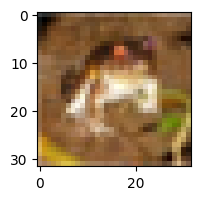

In [9]:
plt.figure(figsize=(2,2))

################## TODO BLOCK
plt.imshow(raw_image)
# plt.imshow(image)
################## END TODO BLOCK


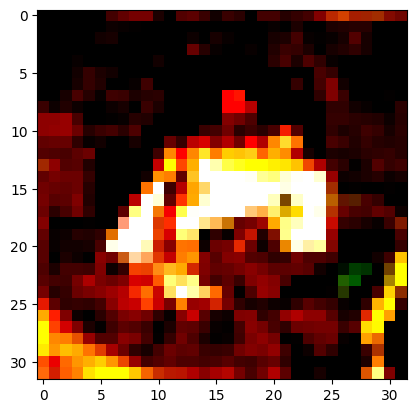

In [10]:
plt.imshow(image.permute(1, 2, 0))


In [11]:
type(train_dataset)

torchvision.datasets.cifar.CIFAR10

**What is the length of the train set?**

In [12]:
length_trainset = len(train_dataset) # TODO OPERAND
print("The length of the train set is", length_trainset)

The length of the train set is 50000


**Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**

  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [13]:
labels_names =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] # TODO OPERAND

The following code allows to visualize 8 images in each category

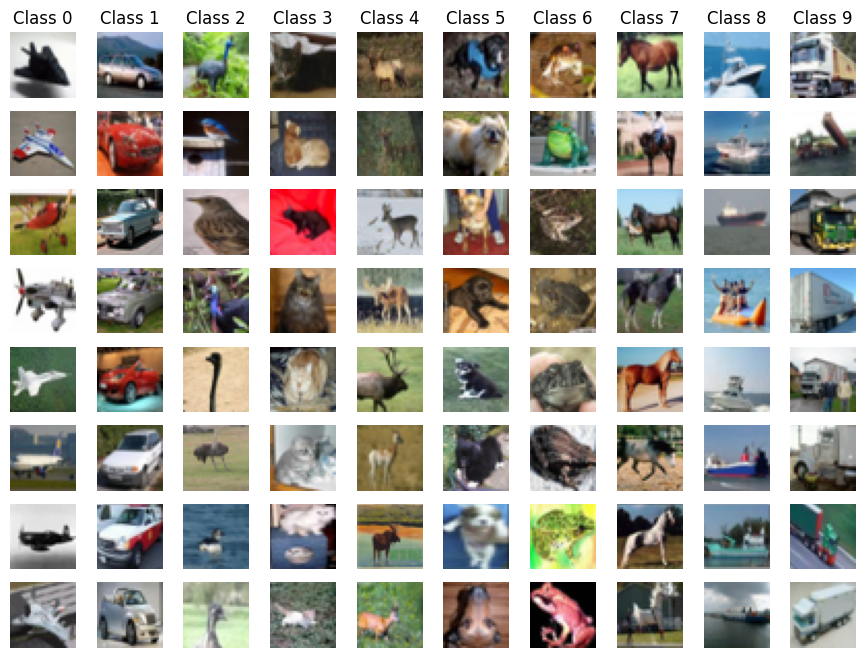

In [14]:
n = 8  # Number of images per class
f, axes = plt.subplots(n, 10, figsize=(11, 8))

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < n and j < len(train_dataset):
        if train_dataset.targets[j] == i:
            axes[count, i].imshow(train_dataset.data[j])  # Show image
            axes[count, i].axis('off')
            if count == 0:
                axes[count, i].set_title(f"Class {i}")  # Set title for first row
            count += 1
        j += 1

plt.show()



<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task.**

In [15]:

# import torch
# import torch.nn as nn

# flatten = nn.Flatten(start_dim=2)  # Create Flatten layer

# x = torch.randn(4, 3, 32, 32)  # Batch of 4 images, shape (4, 3, 32, 32)
# # print(x)
# x_flattened = flatten(x)  # Apply Flatten

# print(x.shape)         # torch.Size([4, 3, 32, 32])
# print(x_flattened.shape)  # torch.Size([4, 3072])  --> 3*32*32 = 3072


In [16]:
import torch.nn as nn

class DenseModel(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(DenseModel, self).__init__()

        # Define here the layers that you want to add

        ################## TODO BLOCK
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,100)
        self.fc5 = nn.Linear(100,num_classes)
        self.relu = nn.ReLU()

        ################## END TODO BLOCK


    def forward(self, x):

        ################## TODO BLOCK
        x = self.flatten(x)   #convert #D to 1D
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)     #the last layer is left as it is. No reLU in the last layer


        ################## END TODO BLOCK

        return x

# Create model instance
model = DenseModel()

# print(model)


**Compute by hand the total number of trainable parameters (weights and biases) in the model.**

Detailed computations here:

################## TODO BLOCK



################## END TODO BLOCK

In [17]:
# Write here the total number of parameters
total_number_parameters_dense = 3*32*32*1024 +1024+1024*512+512+512*256+256+256*100+100+100*10+10 # TODO OPERAND
print(total_number_parameters_dense)

3829590


**Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [18]:
from torchsummary import summary
summary(model.to(device), (3, 32, 32))  # Input shape: (Channels, Height, Width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 1024]       3,146,752
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 3,829,590
Trainable params: 3,829,590
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 14.61
Estima

**Complete the next function.**

- **Define cross-entropy loss**

- **Training Loop: For each epoch, iterate over training batches to compute loss, perform backpropagation, update parameters.**

- **Validation: After each epoch, evaluate the model on the validation set.**


In [19]:
def train_model(model, optimizer, scheduler = None, epochs=10):

    # Define the loss function
    criterion = nn.CrossEntropyLoss()  # TODO OPERAND

    # Store the history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    best_val_acc = 0.0

    model.to(device)

    for epoch in range(epochs):
        model.train()           #sets the model to train mode where the parameters are updated
        train_loss = 0.0
        train_acc = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
             # Convert targets to int64 on CPU if necessary
            # if device.type == 'cpu':
            #     targets = targets.type(torch.int64)

            ################## TODO BLOCK
            optimizer.zero_grad()  #zero the gradients before use
            outputs = model(inputs)     #compute the forward pass
            loss = criterion(outputs, targets)
            loss.backward()      #compute the gradient compuytation for the backward pass::: gradient of L
            optimizer.step()      #update the step w = w-alpha*gradient
            ################## END TODO BLOCK

            # Update of the scheduler at each iteration (non conventional)
            if scheduler is not None:
                scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total_train += targets.size(0)
            train_acc += preds.eq(targets).sum().item()

        train_loss /= total_train
        train_acc = train_acc / total_train

        # Validation stage after each epoch
        model.eval()        #whenever you compute the loss, don't store the gradient, only the loss.  #using model.eval() helps us compute output but the parameters are not changed
        val_loss = 0.0
        val_acc = 0
        total_val = 0

        with torch.no_grad():                         #we don't want a gradient computation, because we just want to validate data
            for inputs, targets in test_loader:         #using the
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # TODO OPERAND
                loss = criterion(outputs, targets)   # TODO OPERAND

                val_loss += loss.item() * inputs.size(0)
                _, preds = outputs.max(1)
                total_val += targets.size(0)
                val_acc += preds.eq(targets).sum().item()

        val_loss /= total_val
        val_acc = val_acc / total_val

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Check for best validation accuracy and save best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())  # Save best model weights

        print(f"Epoch {epoch+1}/{epochs}  -  Train Loss: {train_loss:.4f}  Train Acc: {100*train_acc:.2f}%  -  Val Loss: {val_loss:.4f}  Val Acc: {100*val_acc:.2f}%")

    print(f"Best Validation Accuracy: {100*best_val_acc:.2f}%")

    return history, best_model_weights


**Test your DenseModel(). Use a torch.optim.SGD optimizer (you are free to choose the learning rate)**

In [20]:
model = DenseModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # TODO OPERAND
history, best_weights = train_model(model,optimizer)  # TODO OPERAND

Epoch 1/10  -  Train Loss: 2.2853  Train Acc: 17.63%  -  Val Loss: 2.2471  Val Acc: 25.64%
Epoch 2/10  -  Train Loss: 2.1167  Train Acc: 27.54%  -  Val Loss: 1.9742  Val Acc: 29.69%
Epoch 3/10  -  Train Loss: 1.8920  Train Acc: 32.64%  -  Val Loss: 1.8129  Val Acc: 34.85%
Epoch 4/10  -  Train Loss: 1.7606  Train Acc: 37.25%  -  Val Loss: 1.6932  Val Acc: 39.84%
Epoch 5/10  -  Train Loss: 1.6599  Train Acc: 40.92%  -  Val Loss: 1.6117  Val Acc: 42.48%
Epoch 6/10  -  Train Loss: 1.5828  Train Acc: 43.72%  -  Val Loss: 1.5563  Val Acc: 44.84%
Epoch 7/10  -  Train Loss: 1.5154  Train Acc: 46.07%  -  Val Loss: 1.5165  Val Acc: 46.42%
Epoch 8/10  -  Train Loss: 1.4524  Train Acc: 48.34%  -  Val Loss: 1.5024  Val Acc: 46.96%
Epoch 9/10  -  Train Loss: 1.3964  Train Acc: 50.29%  -  Val Loss: 1.4256  Val Acc: 48.94%
Epoch 10/10  -  Train Loss: 1.3485  Train Acc: 52.05%  -  Val Loss: 1.4084  Val Acc: 49.57%
Best Validation Accuracy: 49.57%


**Discuss the accuracy of your trained model. Is your model better than a random predictor?**

############ TODO BLOCK


The accuracy of the trained model is around 50 percent. This is significantly better than a random predictor since a random predictor would have an accuracy of around 10 percent but the naive model is better than a random predictor.

############ END TODO BLOCK


**The next cell introduces a scheduler. What is the reason for using a scheduler?**

################## TODO BLOCK

The reason for using a scheduler is to update the learning rate as the training time increases.

################## END TODO BLOCK


In [21]:
model = DenseModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)     #uses Stochastic gradient descent
decay_rate = 0.9
decay_steps = 10000
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 2.2647  Train Acc: 17.65%  -  Val Loss: 2.1844  Val Acc: 21.48%
Epoch 2/10  -  Train Loss: 2.0486  Train Acc: 26.54%  -  Val Loss: 1.9316  Val Acc: 30.30%
Epoch 3/10  -  Train Loss: 1.8647  Train Acc: 32.57%  -  Val Loss: 1.7867  Val Acc: 35.63%
Epoch 4/10  -  Train Loss: 1.7422  Train Acc: 37.69%  -  Val Loss: 1.6836  Val Acc: 40.14%
Epoch 5/10  -  Train Loss: 1.6457  Train Acc: 41.08%  -  Val Loss: 1.6012  Val Acc: 43.18%
Epoch 6/10  -  Train Loss: 1.5702  Train Acc: 43.97%  -  Val Loss: 1.5437  Val Acc: 45.45%
Epoch 7/10  -  Train Loss: 1.5041  Train Acc: 46.69%  -  Val Loss: 1.4915  Val Acc: 47.16%
Epoch 8/10  -  Train Loss: 1.4453  Train Acc: 48.81%  -  Val Loss: 1.4798  Val Acc: 47.36%
Epoch 9/10  -  Train Loss: 1.3915  Train Acc: 50.64%  -  Val Loss: 1.4478  Val Acc: 48.45%
Epoch 10/10  -  Train Loss: 1.3427  Train Acc: 52.42%  -  Val Loss: 1.3994  Val Acc: 50.97%
Best Validation Accuracy: 50.97%


**Initialization**: The next cell changes the way the initial weights of the model are computed. Have a look at the impact of the initialization method on the performance. Provide your comments.

############# TODO BLOCK

The performance was slightly improved for the validation test. The training accuracy has drastically increased from around 52 percent in the previous methods to 69 percent after using xavier initialization. However there is just a slight improvement in best validation accuracy



############# END TODO BLOCK

In [22]:
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

model = DenseModel()
# Apply new initialization weights
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)


Epoch 1/10  -  Train Loss: 1.8063  Train Acc: 35.98%  -  Val Loss: 1.6412  Val Acc: 42.09%
Epoch 2/10  -  Train Loss: 1.5496  Train Acc: 45.66%  -  Val Loss: 1.5640  Val Acc: 44.19%
Epoch 3/10  -  Train Loss: 1.4287  Train Acc: 50.04%  -  Val Loss: 1.5017  Val Acc: 46.55%
Epoch 4/10  -  Train Loss: 1.3329  Train Acc: 53.71%  -  Val Loss: 1.4607  Val Acc: 48.82%
Epoch 5/10  -  Train Loss: 1.2503  Train Acc: 56.85%  -  Val Loss: 1.4436  Val Acc: 49.45%
Epoch 6/10  -  Train Loss: 1.1741  Train Acc: 59.53%  -  Val Loss: 1.4257  Val Acc: 49.85%
Epoch 7/10  -  Train Loss: 1.1034  Train Acc: 62.13%  -  Val Loss: 1.4089  Val Acc: 50.90%
Epoch 8/10  -  Train Loss: 1.0359  Train Acc: 64.80%  -  Val Loss: 1.4654  Val Acc: 49.73%
Epoch 9/10  -  Train Loss: 0.9732  Train Acc: 66.72%  -  Val Loss: 1.4258  Val Acc: 51.66%
Epoch 10/10  -  Train Loss: 0.9073  Train Acc: 69.52%  -  Val Loss: 1.4580  Val Acc: 50.65%
Best Validation Accuracy: 51.66%


**Inspect the output of the model for a given input sample : provide its shape.**

In [23]:

# print(image.shape)
# print(image.unsqueeze(0).shape)

image shape
torch.Size([3, 32, 32])
output shape
torch.Size([1, 10])
output
tensor([[-2.5975,  0.4040,  1.4580,  1.8692, -0.0358,  0.9467,  2.8118, -5.1388,
         -0.9936, -0.1530]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(6, device='cuda:0')


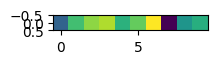

In [24]:
j=0
image , true_label = test_dataset[j]
image = image.to(device)
output = model(image.unsqueeze(0))
print("image shape")
print(image.shape)
print("output shape")
print(output.shape)
print("output")
print(output)
print(torch.argmax(output))
raw_image = output
plt.figure(figsize=(2,2))

################## TODO BLOCK
plt.imshow(raw_image.cpu().detach().numpy())
##################### TODO BLOCK

##################### END TODO BLOCK

**Does the ouput of the model represent the probabilities of each class?**

##################### TODO BLOCK

The output of the model does not represent the probabilities of each class.



##################### END TODO BLOCK

**For the first image of the test set, compute the predicted label in 0,1,...9**

In [25]:
j=0
image , true_label = test_dataset[j]
image = image.to(device)
output = model(image.unsqueeze(0)) # TODO OPERAND
# print(output)

pred = torch.argmax(output) # TODO OPERAND
message = ["Test sample : ",j, ", Label : ",true_label,", Prediction : ",pred.item()]
print(message)

['Test sample : ', 0, ', Label : ', 3, ', Prediction : ', 6]


**Plot eight images in each category, and check the corresponding predictions. Provide your comments.**

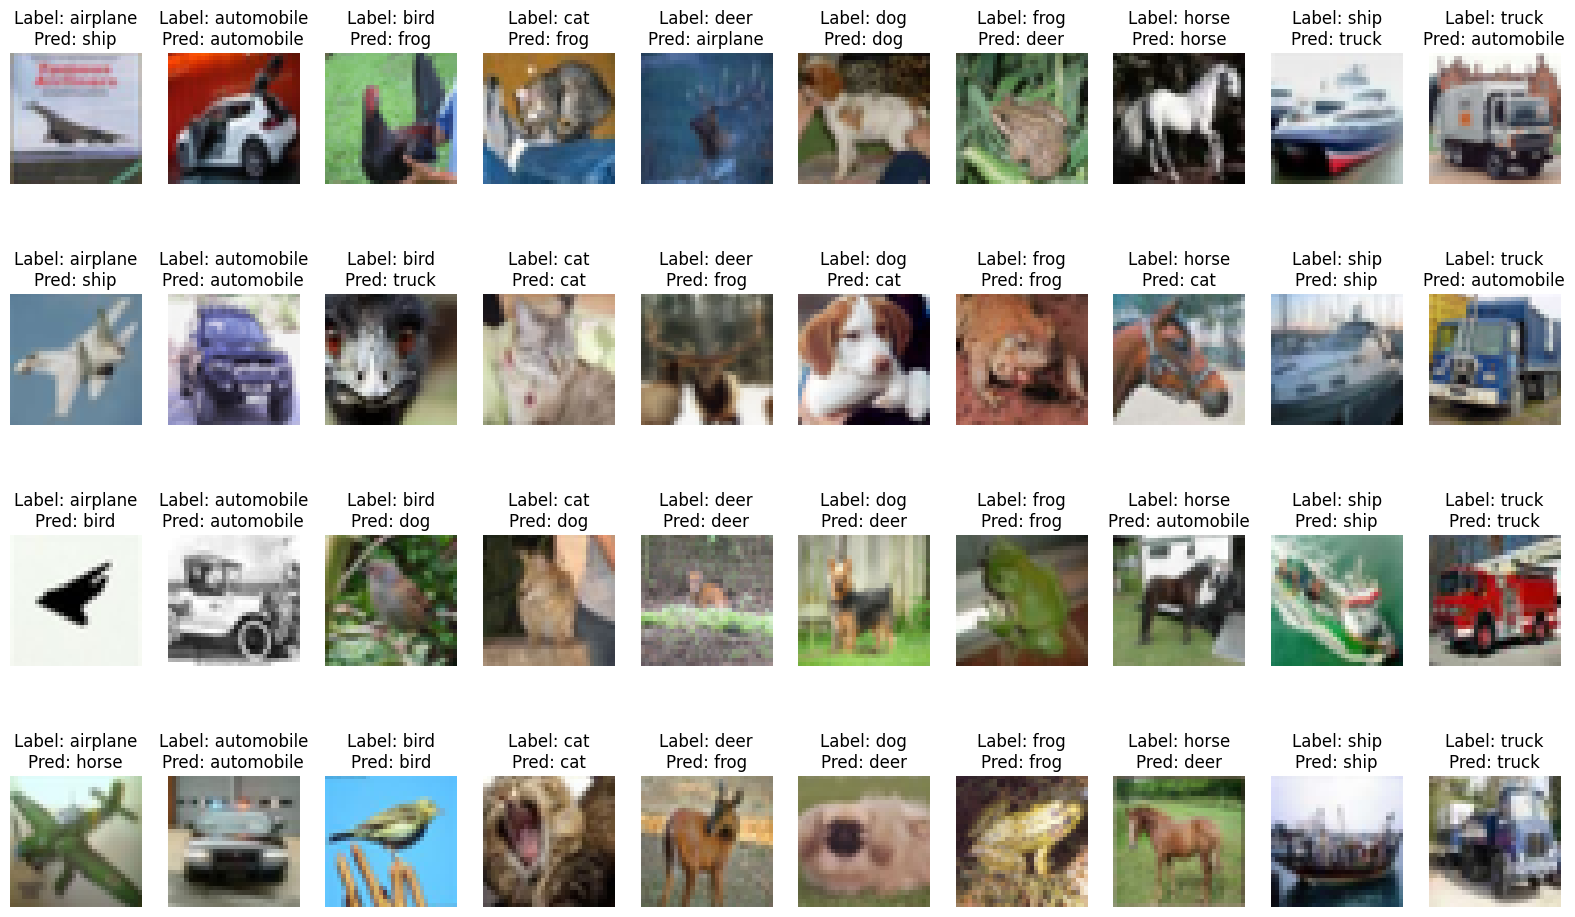

In [26]:
f, axes = plt.subplots(4, 10, figsize=(20, 12))
model.eval()

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < 4:
        if test_dataset.targets[j] == i:
            axes[count, i].imshow(test_dataset.data[j])
            image , _ = test_dataset[j]
            image = image.to(device)
            output = model(image.unsqueeze(0)) # TODO OPERAND
            pred = torch.argmax(output) # TODO OPERAND
            axes[count, i].set_title("Label: "+ labels_names[i] + '\n' + "Pred: " + labels_names[pred.item()])
            axes[count, i].axis('off')
            count += 1
        j += 1

plt.show()

<a id='cnn'></a>

# 3 - Convolutional Neural Network


Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='handcrafted features'></a>
## 3.1 - Visualize 2D-convolution of an image

We will first investigate the effect of using a convolutional layer on the image, with a single filter/kernel applied to each color channel. The following functions allows to define a taylored convolutional layer, and to vizualize the output. Nothing is required from your side, just run the cell.


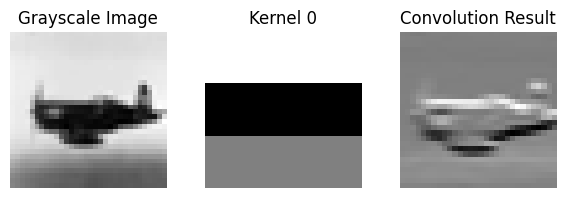

In [27]:
kernel1 = torch.Tensor([[1, 1, 1],[-1, -1, -1],[0, 0, 0]])  # TODO OPERAND
model = FixedKernels_processing(kernel1)
image,_ = train_dataset[115]
model.visualize(image = image)

Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)




**Define your own kernel of shape (3,3), specialized in the detection of horizontal lines in an image**

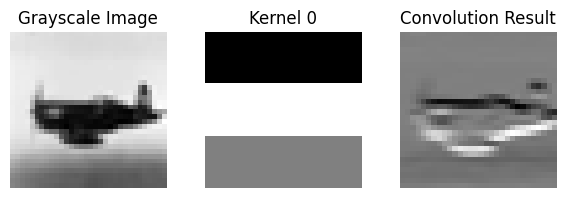

In [28]:

kernel2 = torch.Tensor([[-1, -1, -1],[1, 1, 1],[0, 0, 0]])  # TODO OPERAND
model = FixedKernels_processing(kernel2)
image,_ = train_dataset[115]
model.visualize(image = image)

**Same question, but this time use a kernel specialized in the detection of vertical lines**

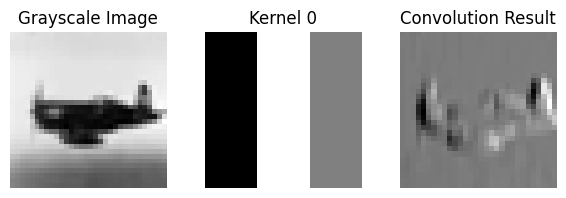

In [29]:
kernel_v = torch.Tensor([[-1, 1, 0],[-1, 1, 0],[-1, 1, 0]]) # TODO OPERAND
model = FixedKernels_processing(kernel_v)
image,_ = train_dataset[115]
model.visualize(image = image)

**The following cell allows to vizualise the effect of various filters on the image. Comment on the effect of the filters that are used**

################## TODO BLOCK

The top kernel is designed to filter horizontal edges and the rotated kernel is used to filter vertical edges.

The diagonal kernel is used to filter edges along a diagonal and it's rotation is used to filter edges along the other diagonal.

The straights+diagonals will help us detect edges as these filters are combining the effect of vertical and diagonal(both diagonals) and horizontal and diagonal(both diagonal).



################## END TODO BLOCK



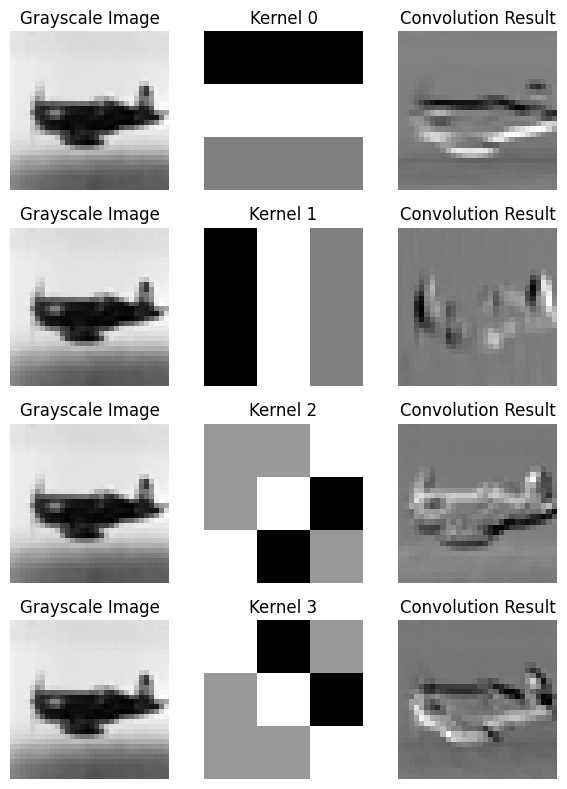

In [30]:
top=np.array([[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]],dtype=np.float32)

straights = [ torch.Tensor(np.rot90(top, i).copy()) for i in range(2) ]

br=[[ 0,   0,   1],
    [ 0,   1,-1.5],
    [ 1,-1.5,   0]]
diags = [ torch.Tensor(np.rot90(br, i).copy()) for i in range(2) ]

kernels = straights+diags
# count = 0
# for i in kernels:
#   count+=1
# print(count)
preprocessing = FixedKernels_processing(kernels)

preprocessing.visualize(image = image)


We will use these features as a preprocessing.

**Define a model which first applies the previously defined** `preprocessing` **model as a preprocessing applied to the input images. Then, apply a relu. Next, add a MaxPooling2D layer using** `nn.MaxPool2d(kernel_size=2, stride=2)`. **Flatten the result and add a final dense layer.**

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class handcrafted_model(nn.Module):
    def __init__(self, preprocessing = preprocessing, num_classes=10):

        super(handcrafted_model, self).__init__()

        self.preprocessing = preprocessing

        # ReLU Layer
        self.relu = nn.ReLU()   # TODO OPERAND

        # MaxPooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2,stride = 2)  # TODO OPERAND

        # Fully Connected Layer (after flattening)
        self.fc = nn.Linear(4*15*15, num_classes) # TODO OPERAND

    def forward(self, x):

        if x.ndim != 4:
            raise ValueError("Input must be a 4D tensor of shape [N, C, H, W].")

        # Apply the preprocessing
        x = self.preprocessing(x)  # TODO OPERAND

        # Apply ReLU activation
        x = self.relu(x)  # TODO OPERAND

        # Apply MaxPooling
        x =  self.pool(x) # TODO OPERAND

        # Flatten the result
        x = torch.flatten(x, start_dim=1)

        # Apply fully connected layer
        x = self.fc(x)# TODO OPERAND

        return x

model = handcrafted_model()

number_param = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {number_param}")

Total parameters: 9046


**Train the model and provide your comments**

################## TODO BLOCK
The accuracy of the model is even worse than before. It is because, we are just applying some transformations(filters) to our original image and feeding the new images in the neural network. Although these steps are done to gain additional features, just training with these features cause loss of information, resulting in worse accuracy.


################## END TODO BLOCK


In [32]:
model = handcrafted_model()
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # TODO OPERAND
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)   # TODO OPERAND


Epoch 1/10  -  Train Loss: 2.1398  Train Acc: 22.24%  -  Val Loss: 2.0756  Val Acc: 26.42%
Epoch 2/10  -  Train Loss: 2.0352  Train Acc: 28.49%  -  Val Loss: 2.0226  Val Acc: 29.54%
Epoch 3/10  -  Train Loss: 1.9930  Train Acc: 30.68%  -  Val Loss: 1.9938  Val Acc: 31.18%
Epoch 4/10  -  Train Loss: 1.9633  Train Acc: 32.05%  -  Val Loss: 1.9656  Val Acc: 32.09%
Epoch 5/10  -  Train Loss: 1.9392  Train Acc: 33.02%  -  Val Loss: 1.9462  Val Acc: 32.85%
Epoch 6/10  -  Train Loss: 1.9189  Train Acc: 33.86%  -  Val Loss: 1.9296  Val Acc: 33.35%
Epoch 7/10  -  Train Loss: 1.9016  Train Acc: 34.57%  -  Val Loss: 1.9132  Val Acc: 34.16%
Epoch 8/10  -  Train Loss: 1.8860  Train Acc: 35.25%  -  Val Loss: 1.9015  Val Acc: 34.35%
Epoch 9/10  -  Train Loss: 1.8722  Train Acc: 35.84%  -  Val Loss: 1.8897  Val Acc: 35.16%
Epoch 10/10  -  Train Loss: 1.8601  Train Acc: 36.48%  -  Val Loss: 1.8800  Val Acc: 35.45%
Best Validation Accuracy: 35.45%


<a id='first_cnn'></a>
## 3.2 - Create your first CNN

**Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [33]:
class CnnModel(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10):

        super(CnnModel, self).__init__()

        ################# TODO BLOCK
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels = 8,out_channels = 32,kernel_size = 3,stride = 1, padding= 0)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3,stride = 1, padding= 0)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*5*5,408)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(408,num_classes)

        ################# END TODO BLOCK


    def forward(self, x):

        ################# TODO BLOCK
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)

        ################# END TODO BLOCK

        return x

cnn = CnnModel()

**Compute by hand the number of trainable parameters in this network.  Are there more or less than the simple dense network of section 1?  Why?**


################## TODO BLOCK

For Conv1, #param = (3x3x3+1)x8=224

For Conv2, #param = (3x3x8+1)x8 = 584

For Conv3, #param = (3x3x8+1)x32=2336

For Conv4, #param = (3x3x32+1)x32 = 9248

For dense layer, #param = (32x5x5x408+408)=326808

For Last layer, #param = 408x10+10 = 4090

Total #param = 343290

There are less parameters than the dense network of section 1 because using CNN, we intend to train the distinguishing filters themselves instead of all the parameters of the dense neural network.

################## END TODO BLOCK

In [85]:
# Put here the result of your computation
total_number_parameters_cnn = 343290 # TODO OPERAND

 **Confirm with** `summary()`

In [35]:
################## TODO BLOCK
from torchsummary import summary
summary(cnn.to(device), (3, 32, 32))  # Input shape: (Channels, Height, Width)

################## END TODO BLOCK

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
              ReLU-2            [-1, 8, 30, 30]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 32, 12, 12]           2,336
              ReLU-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           9,248
              ReLU-9           [-1, 32, 10, 10]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
          Flatten-11                  [-1, 800]               0
           Linear-12                  [-1, 408]         326,808
             ReLU-13                  [-1, 408]               0
           Linear-14                   

**Train the network for 10 epochs. How does the validation accuracy change with each epoch?**

In [36]:
################## TODO BLOCK

def train_model(model, optimizer, scheduler = None, epochs=10):

    # Define the loss function
    criterion = nn.CrossEntropyLoss()  # TODO OPERAND

    # Store the history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    best_val_acc = 0.0

    model.to(device)

    for epoch in range(epochs):
        model.train()           #sets the model to train mode where the parameters are updated
        train_loss = 0.0
        train_acc = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
             # Convert targets to int64 on CPU if necessary
            # if device.type == 'cpu':
            #     targets = targets.type(torch.int64)

            ################## TODO BLOCK
            optimizer.zero_grad()  #zero the gradients before use
            outputs = model(inputs)     #compute the forward pass
            loss = criterion(outputs, targets)
            loss.backward()      #compute the gradient compuytation for the backward pass::: gradient of L
            optimizer.step()      #update the step w = w-alpha*gradient
            ################## END TODO BLOCK

            # Update of the scheduler at each iteration (non conventional)
            if scheduler is not None:
                scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total_train += targets.size(0)
            train_acc += preds.eq(targets).sum().item()

        train_loss /= total_train
        train_acc = train_acc / total_train

        # Validation stage after each epoch
        model.eval()        #whenever you compute the loss, don't store the gradient, only the loss.  #using model.eval() helps us compute output but the parameters are not changed
        val_loss = 0.0
        val_acc = 0
        total_val = 0

        with torch.no_grad():                         #we don't want a gradient computation, because we just want to validate data
            for inputs, targets in test_loader:         #using the
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # TODO OPERAND
                loss = criterion(outputs, targets)   # TODO OPERAND

                val_loss += loss.item() * inputs.size(0)
                _, preds = outputs.max(1)
                total_val += targets.size(0)
                val_acc += preds.eq(targets).sum().item()

        val_loss /= total_val
        val_acc = val_acc / total_val

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Check for best validation accuracy and save best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())  # Save best model weights

        print(f"Epoch {epoch+1}/{epochs}  -  Train Loss: {train_loss:.4f}  Train Acc: {100*train_acc:.2f}%  -  Val Loss: {val_loss:.4f}  Val Acc: {100*val_acc:.2f}%")

    print(f"Best Validation Accuracy: {100*best_val_acc:.2f}%")

    return history, best_model_weights


################## END TODO BLOCK

In [37]:
model = cnn
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # TODO OPERAND
history, best_weights = train_model(model,optimizer)  # TODO OPERAND

Epoch 1/10  -  Train Loss: 2.3000  Train Acc: 10.39%  -  Val Loss: 2.2928  Val Acc: 13.85%
Epoch 2/10  -  Train Loss: 2.2042  Train Acc: 20.51%  -  Val Loss: 2.0527  Val Acc: 25.60%
Epoch 3/10  -  Train Loss: 1.9810  Train Acc: 28.74%  -  Val Loss: 1.9056  Val Acc: 32.10%
Epoch 4/10  -  Train Loss: 1.8631  Train Acc: 33.61%  -  Val Loss: 1.7848  Val Acc: 36.32%
Epoch 5/10  -  Train Loss: 1.7472  Train Acc: 37.36%  -  Val Loss: 1.7022  Val Acc: 40.08%
Epoch 6/10  -  Train Loss: 1.6487  Train Acc: 41.06%  -  Val Loss: 1.6000  Val Acc: 41.95%
Epoch 7/10  -  Train Loss: 1.5716  Train Acc: 43.84%  -  Val Loss: 1.5492  Val Acc: 44.79%
Epoch 8/10  -  Train Loss: 1.5182  Train Acc: 45.75%  -  Val Loss: 1.4716  Val Acc: 47.68%
Epoch 9/10  -  Train Loss: 1.4654  Train Acc: 47.50%  -  Val Loss: 1.4663  Val Acc: 48.28%
Epoch 10/10  -  Train Loss: 1.4224  Train Acc: 49.11%  -  Val Loss: 1.3949  Val Acc: 50.25%
Best Validation Accuracy: 50.25%


The validation and train accuracy are gradually increasing to around 50 percent in the model.

**Plot the evolution of (train/val) accuracy through epochs**

[0.10388, 0.20506, 0.28738, 0.33608, 0.37362, 0.41062, 0.4384, 0.45754, 0.47502, 0.49112]
[0.1385, 0.256, 0.321, 0.3632, 0.4008, 0.4195, 0.4479, 0.4768, 0.4828, 0.5025]


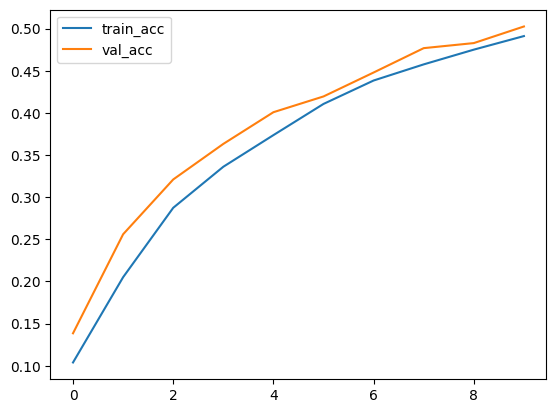

In [38]:

################## TODO BLOCK
print(history["train_acc"])
print(history["val_acc"])
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.show()

################## END TODO BLOCK



**Consider now a batch size of 32 and consider the above CNN. Try adding 3 BatchNormalization layers to this model, one after each max-pooling layer and one before the last layer. Use a dropout layer just before the last linear layer.**

In [39]:
################## TODO BLOCK
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)


################## END TODO BLOCK

In [40]:
class CnnModel2(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10):

        super(CnnModel2, self).__init__()

        ################# TODO BLOCK
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(in_channels = 8,out_channels = 32,kernel_size = 3,stride = 1, padding= 0)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3,stride = 1, padding= 0)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*5*5,408)
        self.relu5 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(408)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(408,num_classes)

        ################# END TODO BLOCK


    def forward(self, x):

        ################# TODO BLOCK
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)

        ################# END TODO BLOCK

        return x

cnn2 = CnnModel2()

**Train the model. What is the impact of batch normalization on the model's performance? Why?**

################## TODO BLOCK

+8.11% increase in validation accuracy suggests that BN has made training more effective by stabilizing activations, improving gradient flow, and reducing overfitting.


################## END TODO BLOCK


In [41]:
################## TODO BLOCK

model = cnn2
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # TODO OPERAND
history, best_weights = train_model(model,optimizer)  # TODO OPERAND

################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 2.0857  Train Acc: 23.33%  -  Val Loss: 1.8123  Val Acc: 34.76%
Epoch 2/10  -  Train Loss: 1.6666  Train Acc: 39.53%  -  Val Loss: 1.5142  Val Acc: 45.19%
Epoch 3/10  -  Train Loss: 1.4469  Train Acc: 48.26%  -  Val Loss: 1.4044  Val Acc: 48.83%
Epoch 4/10  -  Train Loss: 1.3020  Train Acc: 53.77%  -  Val Loss: 1.3342  Val Acc: 53.90%
Epoch 5/10  -  Train Loss: 1.1860  Train Acc: 58.35%  -  Val Loss: 1.2989  Val Acc: 53.98%
Epoch 6/10  -  Train Loss: 1.0812  Train Acc: 62.26%  -  Val Loss: 1.1437  Val Acc: 59.56%
Epoch 7/10  -  Train Loss: 0.9951  Train Acc: 65.52%  -  Val Loss: 1.1148  Val Acc: 61.56%
Epoch 8/10  -  Train Loss: 0.9146  Train Acc: 68.32%  -  Val Loss: 1.0950  Val Acc: 63.01%
Epoch 9/10  -  Train Loss: 0.8442  Train Acc: 70.83%  -  Val Loss: 1.0691  Val Acc: 63.08%
Epoch 10/10  -  Train Loss: 0.7762  Train Acc: 73.14%  -  Val Loss: 1.0467  Val Acc: 64.31%
Best Validation Accuracy: 64.31%


**Plot the evolution of (train/val) accuracy through epochs**

[0.23328, 0.39534, 0.4826, 0.53766, 0.58354, 0.62262, 0.65524, 0.68322, 0.70832, 0.73136]
[0.3476, 0.4519, 0.4883, 0.539, 0.5398, 0.5956, 0.6156, 0.6301, 0.6308, 0.6431]


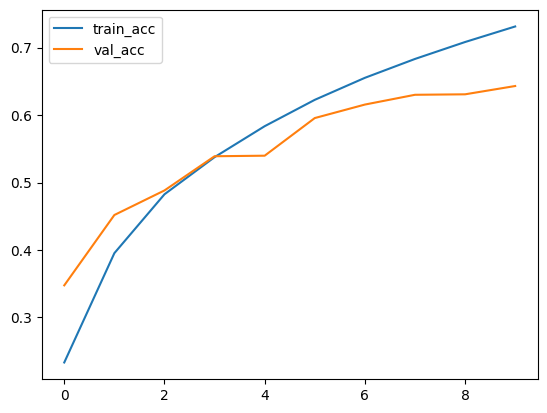

In [43]:

################## TODO BLOCK

print(history["train_acc"])
print(history["val_acc"])
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.show()


################## END TODO BLOCK



<a id='results'></a>

## 3.3 - Study the predictions

**Consider image number 3 in the test set. Display the image and the output probabilities associated to each category**

tensor([[ 5.6519, -0.3581,  1.4041, -1.3689,  1.6133, -3.7984, -3.0779, -1.5029,
          2.7071, -0.5875]], device='cuda:0', grad_fn=<AddmmBackward0>)


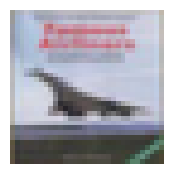

{'airplane': 0.9167112112045288, 'automobile': 0.002249674638733268, 'bird': 0.01310537289828062, 'cat': 0.0008187241619452834, 'deer': 0.01615540124475956, 'dog': 7.211773481685668e-05, 'frog': 0.00014823164383415133, 'horse': 0.0007160528912208974, 'ship': 0.04823460802435875, 'truck': 0.0017885837005451322}


In [46]:
# Load the best weights and set the model to evaluation mode
cnn2.load_state_dict(best_weights)  # Use the best weights
cnn2.eval()

i_sample = 3

# Retrieve the transformed image and label from the test dataset
image, label = test_dataset[i_sample] # TODO OPERAND
image = image.to(device)

# Add a batch dimension and compute the model's output
output = cnn2(image.unsqueeze(0))  # TODO OPERAND
print(output)

# # Apply softmax to get output probabilities
softmax = torch.nn.Softmax(dim=1)  # TODO OPERAND
output_proba = softmax(output)  # TODO OPERAND

# # Display the raw image (from the original dataset data)
raw_image = test_dataset.data[i_sample]
plt.figure(figsize=(2,2))
plt.imshow(raw_image)
plt.axis("off")
plt.show()

# Create a dictionary mapping label names to their probability
dictionnary = {labels_names[i]: output_proba.squeeze()[i].item() for i in range(10)}
print(dictionnary)



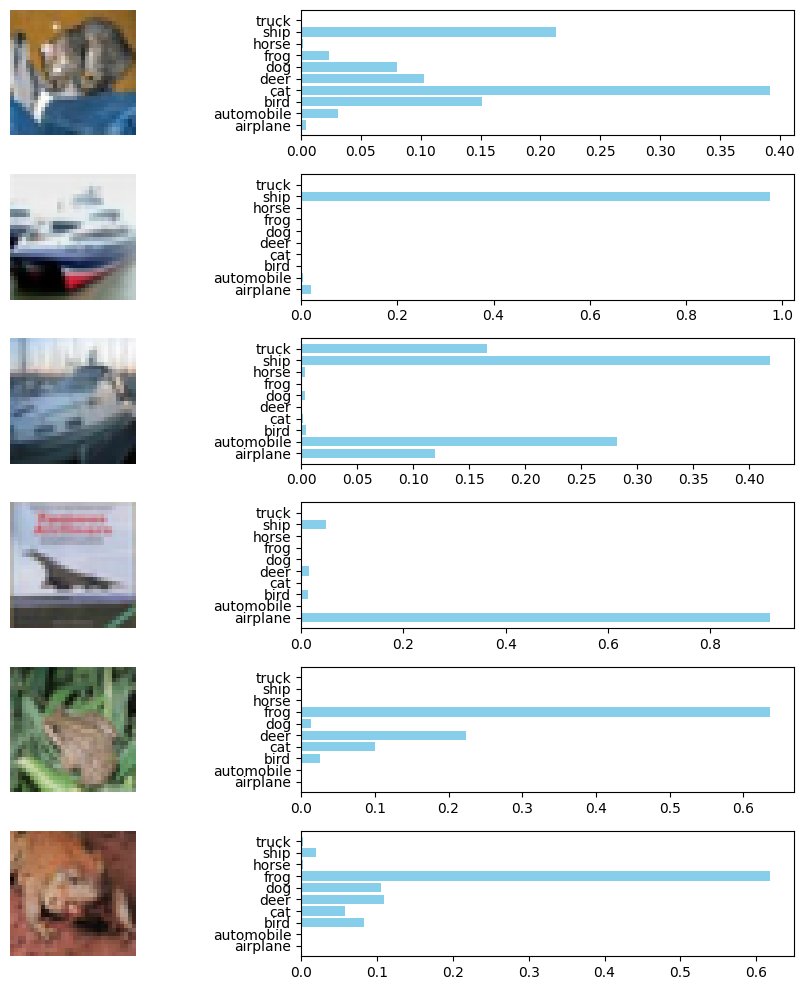

In [47]:
# Plot an image and the corresponding output probabilities of a given model.

plot_proba_from_model(cnn, test_dataset, range(6),device)

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.

**Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

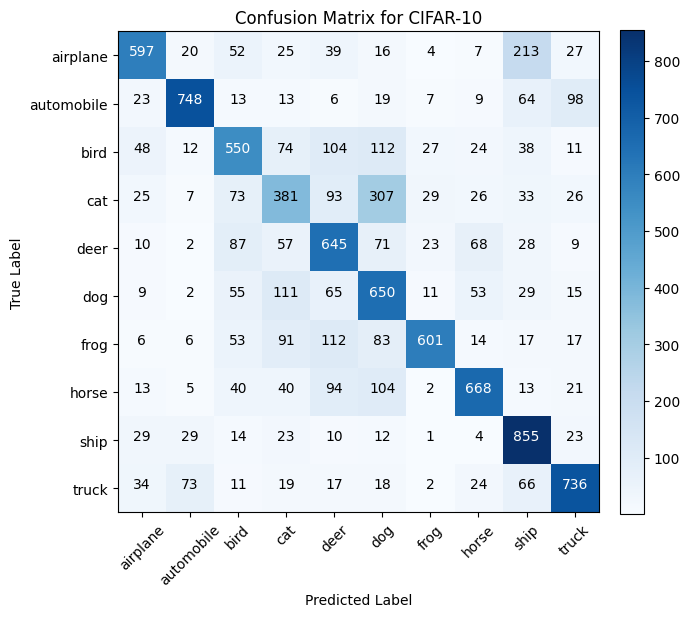

In [48]:
import sklearn.metrics as metrics

cnn.to(device)

# Set the model to evaluation mode
cnn.eval()

all_preds = []
all_labels = []

# Collect all predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix using scikit-learn
cm= metrics.confusion_matrix(all_labels, all_preds)

plot_confusion_matrix(cm)



There is a relatively higher density in the diagonals of the confusion matrix which indicates that decent amount of proper classifications are being performed by the model. However, there are instances when objects with similar images are classified as the other, such as deer and horse, cat and dogs, ship and airplanes and so on.

## 3.4 Try different optimizers

**You may compare the current model (trained with SGD and exponential scheduler) with the Adam optimizer (with and without scheduler)**. You may also consider other algorithms if you wish (RMSprop, Adagrad, for instance).

In [89]:
################## TODO BLOCK
#ADAM without scheduler
model = cnn2
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # TODO OPERAND
history, best_weights = train_model(model,optimizer)  # TODO OPERAND
################## END TODO BLOCK


Epoch 1/10  -  Train Loss: 1.3940  Train Acc: 49.82%  -  Val Loss: 1.1429  Val Acc: 59.34%
Epoch 2/10  -  Train Loss: 1.0445  Train Acc: 63.23%  -  Val Loss: 1.0388  Val Acc: 63.25%
Epoch 3/10  -  Train Loss: 0.8652  Train Acc: 69.78%  -  Val Loss: 0.9152  Val Acc: 68.13%
Epoch 4/10  -  Train Loss: 0.7330  Train Acc: 74.53%  -  Val Loss: 0.9316  Val Acc: 69.06%
Epoch 5/10  -  Train Loss: 0.6183  Train Acc: 78.24%  -  Val Loss: 0.9214  Val Acc: 69.68%
Epoch 6/10  -  Train Loss: 0.5121  Train Acc: 81.96%  -  Val Loss: 1.0042  Val Acc: 68.94%
Epoch 7/10  -  Train Loss: 0.4160  Train Acc: 85.50%  -  Val Loss: 1.0633  Val Acc: 68.59%
Epoch 8/10  -  Train Loss: 0.3290  Train Acc: 88.44%  -  Val Loss: 1.2218  Val Acc: 69.17%
Epoch 9/10  -  Train Loss: 0.2616  Train Acc: 90.85%  -  Val Loss: 1.3584  Val Acc: 68.22%
Epoch 10/10  -  Train Loss: 0.2099  Train Acc: 92.65%  -  Val Loss: 1.5599  Val Acc: 67.58%
Best Validation Accuracy: 69.68%


[0.4982, 0.63226, 0.69784, 0.7453, 0.7824, 0.81958, 0.85496, 0.88442, 0.90852, 0.92652]
[0.5934, 0.6325, 0.6813, 0.6906, 0.6968, 0.6894, 0.6859, 0.6917, 0.6822, 0.6758]


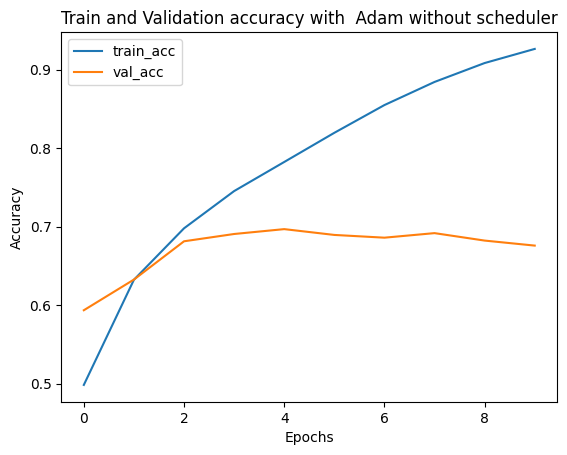

In [90]:
################## TODO BLOCK

print(history["train_acc"])
print(history["val_acc"])
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracy with  Adam without scheduler")
plt.show()
################## END TODO BLOCK


In [91]:
#CNN Trained with ADAM with scheduler
model = cnn2
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # TODO OPERAND
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)   # TODO OPERAND

Epoch 1/10  -  Train Loss: 1.4268  Train Acc: 48.60%  -  Val Loss: 1.2302  Val Acc: 56.06%
Epoch 2/10  -  Train Loss: 1.0616  Train Acc: 62.32%  -  Val Loss: 1.0636  Val Acc: 62.34%
Epoch 3/10  -  Train Loss: 0.8853  Train Acc: 68.98%  -  Val Loss: 0.9482  Val Acc: 67.50%
Epoch 4/10  -  Train Loss: 0.7526  Train Acc: 73.71%  -  Val Loss: 0.9836  Val Acc: 66.83%
Epoch 5/10  -  Train Loss: 0.6322  Train Acc: 77.76%  -  Val Loss: 0.9574  Val Acc: 68.82%
Epoch 6/10  -  Train Loss: 0.5230  Train Acc: 81.78%  -  Val Loss: 1.0218  Val Acc: 68.36%
Epoch 7/10  -  Train Loss: 0.4127  Train Acc: 85.33%  -  Val Loss: 1.0828  Val Acc: 69.03%
Epoch 8/10  -  Train Loss: 0.3228  Train Acc: 88.52%  -  Val Loss: 1.2875  Val Acc: 67.68%
Epoch 9/10  -  Train Loss: 0.2438  Train Acc: 91.38%  -  Val Loss: 1.4250  Val Acc: 67.15%
Epoch 10/10  -  Train Loss: 0.1908  Train Acc: 93.30%  -  Val Loss: 1.6047  Val Acc: 67.56%
Best Validation Accuracy: 69.03%


[0.48598, 0.62318, 0.68982, 0.73706, 0.7776, 0.81782, 0.85328, 0.88518, 0.91382, 0.93304]
[0.5606, 0.6234, 0.675, 0.6683, 0.6882, 0.6836, 0.6903, 0.6768, 0.6715, 0.6756]


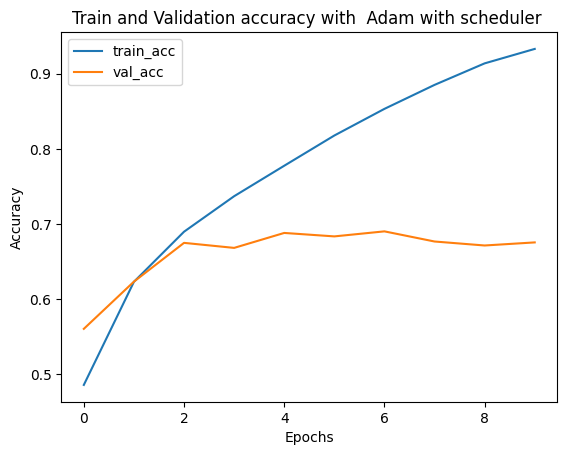

In [92]:
################## TODO BLOCK

print(history["train_acc"])
print(history["val_acc"])
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracy with  Adam with scheduler ")
plt.show()
################## END TODO BLOCK


In [55]:
#CNN trained with SGD and exponential scheduler
model = cnn2
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # TODO OPERAND
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)   # TODO OPERAND


Epoch 1/10  -  Train Loss: 1.7751  Train Acc: 35.91%  -  Val Loss: 1.5488  Val Acc: 44.57%
Epoch 2/10  -  Train Loss: 1.4472  Train Acc: 47.51%  -  Val Loss: 1.3880  Val Acc: 49.55%
Epoch 3/10  -  Train Loss: 1.3117  Train Acc: 53.27%  -  Val Loss: 1.2944  Val Acc: 53.57%
Epoch 4/10  -  Train Loss: 1.2135  Train Acc: 56.98%  -  Val Loss: 1.2373  Val Acc: 55.88%
Epoch 5/10  -  Train Loss: 1.1300  Train Acc: 60.33%  -  Val Loss: 1.2201  Val Acc: 57.43%
Epoch 6/10  -  Train Loss: 1.0610  Train Acc: 62.73%  -  Val Loss: 1.1136  Val Acc: 60.81%
Epoch 7/10  -  Train Loss: 0.9963  Train Acc: 65.13%  -  Val Loss: 1.1637  Val Acc: 59.55%
Epoch 8/10  -  Train Loss: 0.9402  Train Acc: 67.14%  -  Val Loss: 1.1017  Val Acc: 62.15%
Epoch 9/10  -  Train Loss: 0.8843  Train Acc: 69.09%  -  Val Loss: 1.0564  Val Acc: 63.08%
Epoch 10/10  -  Train Loss: 0.8359  Train Acc: 70.97%  -  Val Loss: 1.0489  Val Acc: 64.49%
Best Validation Accuracy: 64.49%


[0.3168, 0.52368, 0.61422, 0.66384, 0.70196, 0.72742, 0.75612, 0.77856, 0.79368, 0.81376]
[0.4599, 0.5729, 0.6375, 0.6549, 0.7053, 0.7175, 0.7262, 0.7238, 0.7428, 0.7441]


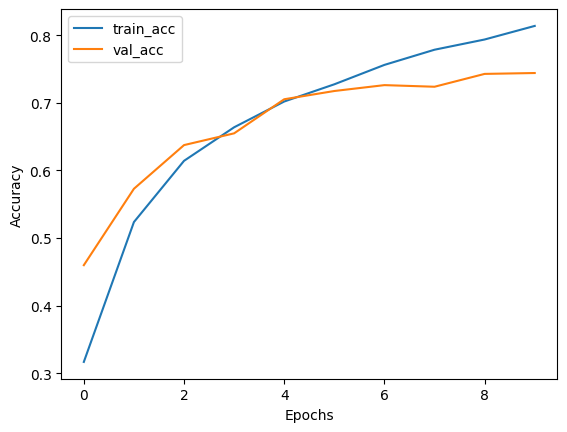

In [86]:
################## TODO BLOCK

print(history["train_acc"])
print(history["val_acc"])
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracy with  SGD with scheduler")
plt.legend()
plt.show()
################## END TODO BLOCK


**Plot the evolution of (train/val) accuracy through epochs**

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10. You will:**


*   Download a model from `torchvision.models`.
*   Print its summary, understand its architecture.
*   If any, identify the layer(s) which play the role of a classifier, as opposed to the layers used for feature extraction.
*   Modify the model so that it ouputs the correct number of classes.
*   If the model has a large number of trainable parameters, you may consider freezing the feacture extraction layers (= make them non-trainable), only optimizing the last dense layers.
*   Train the model



In [79]:
import torchvision.models as models
# Load a ResNet model (e.g., ResNet-18)
model = models.resnet18(pretrained=True)

# Print the model architecture
# print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(summary(model, input_size=(3, 32, 32)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [80]:
num_classes = 10
in_features = model.fc.in_features  # Get input features of the last fully connected layer
model.fc = nn.Linear(in_features, num_classes)  # Replace the final layer with a new one

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [82]:
# # Freeze feature extraction layers (do not train them)
# for param in model.parameters():
#     param.requires_grad = False

# # Only the final classifier layer will be trained now
# for param in model.fc.parameters():
#     param.requires_grad = True

**Plot several images with their predictions. Any comment?**

In [81]:
################## TODO BLOCK

# model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) # TODO OPERAND
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)   # TODO OPERAND
################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 1.9232  Train Acc: 31.68%  -  Val Loss: 1.5756  Val Acc: 45.99%
Epoch 2/10  -  Train Loss: 1.3316  Train Acc: 52.37%  -  Val Loss: 1.2101  Val Acc: 57.29%
Epoch 3/10  -  Train Loss: 1.1017  Train Acc: 61.42%  -  Val Loss: 1.1270  Val Acc: 63.75%
Epoch 4/10  -  Train Loss: 0.9615  Train Acc: 66.38%  -  Val Loss: 1.0925  Val Acc: 65.49%
Epoch 5/10  -  Train Loss: 0.8555  Train Acc: 70.20%  -  Val Loss: 0.8523  Val Acc: 70.53%
Epoch 6/10  -  Train Loss: 0.7936  Train Acc: 72.74%  -  Val Loss: 0.8315  Val Acc: 71.75%
Epoch 7/10  -  Train Loss: 0.7074  Train Acc: 75.61%  -  Val Loss: 0.7985  Val Acc: 72.62%
Epoch 8/10  -  Train Loss: 0.6480  Train Acc: 77.86%  -  Val Loss: 0.8303  Val Acc: 72.38%
Epoch 9/10  -  Train Loss: 0.6052  Train Acc: 79.37%  -  Val Loss: 0.7671  Val Acc: 74.28%
Epoch 10/10  -  Train Loss: 0.5366  Train Acc: 81.38%  -  Val Loss: 0.7798  Val Acc: 74.41%
Best Validation Accuracy: 74.41%


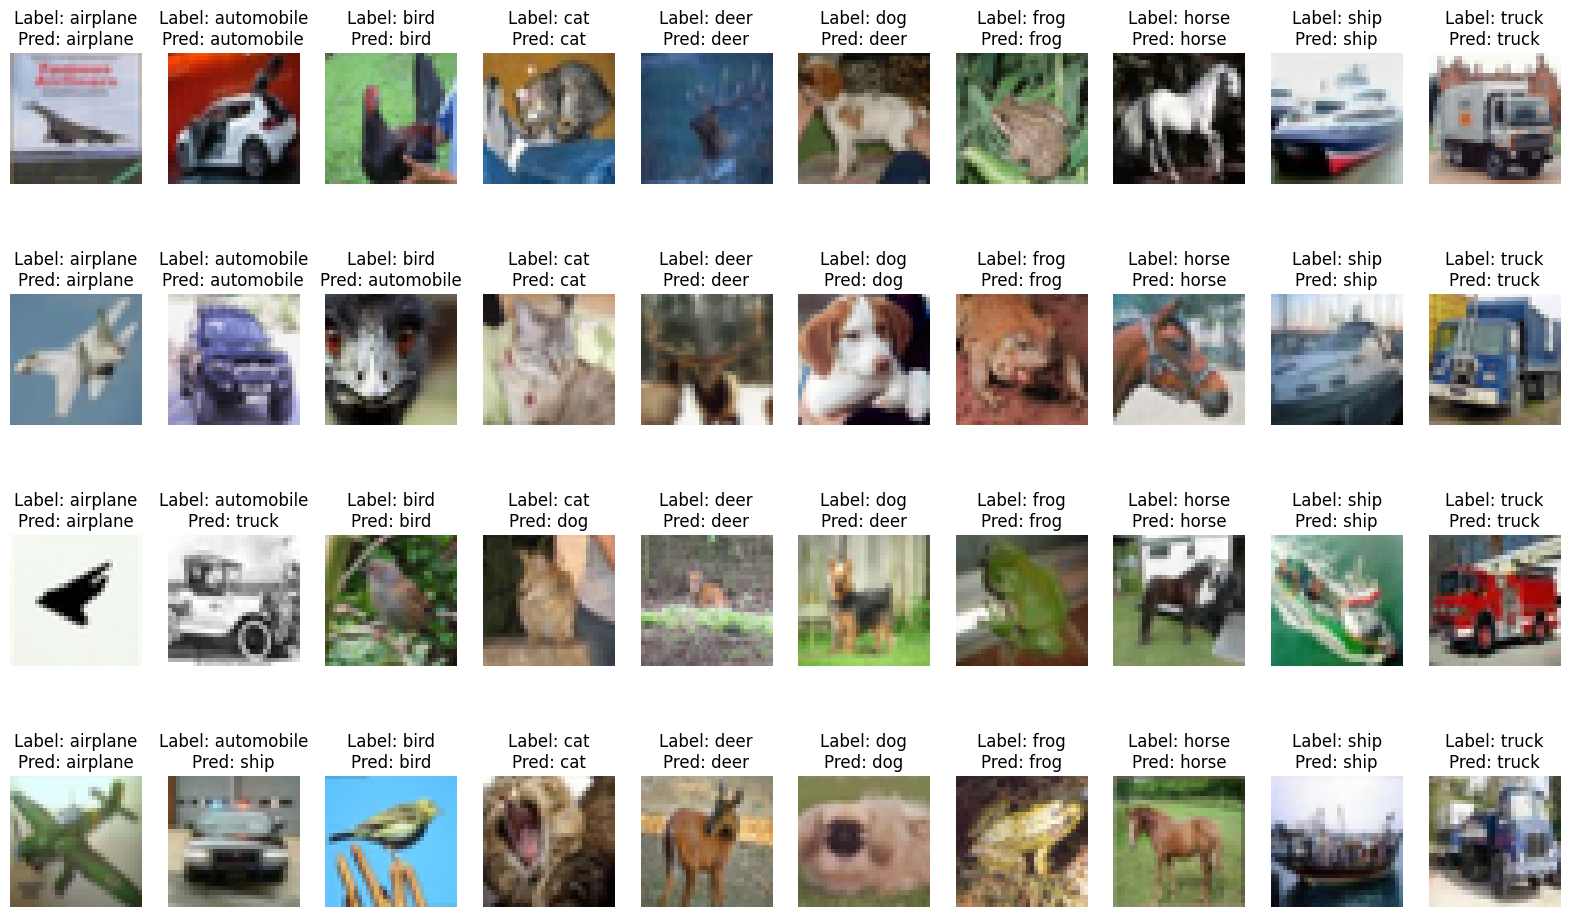

In [83]:
f, axes = plt.subplots(4, 10, figsize=(20, 12))
model.eval()

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < 4:
        if test_dataset.targets[j] == i:
            axes[count, i].imshow(test_dataset.data[j])
            image , _ = test_dataset[j]
            image = image.to(device)
            output = model(image.unsqueeze(0)) # TODO OPERAND
            pred = torch.argmax(output) # TODO OPERAND
            axes[count, i].set_title("Label: "+ labels_names[i] + '\n' + "Pred: " + labels_names[pred.item()])
            axes[count, i].axis('off')
            count += 1
        j += 1

plt.show()

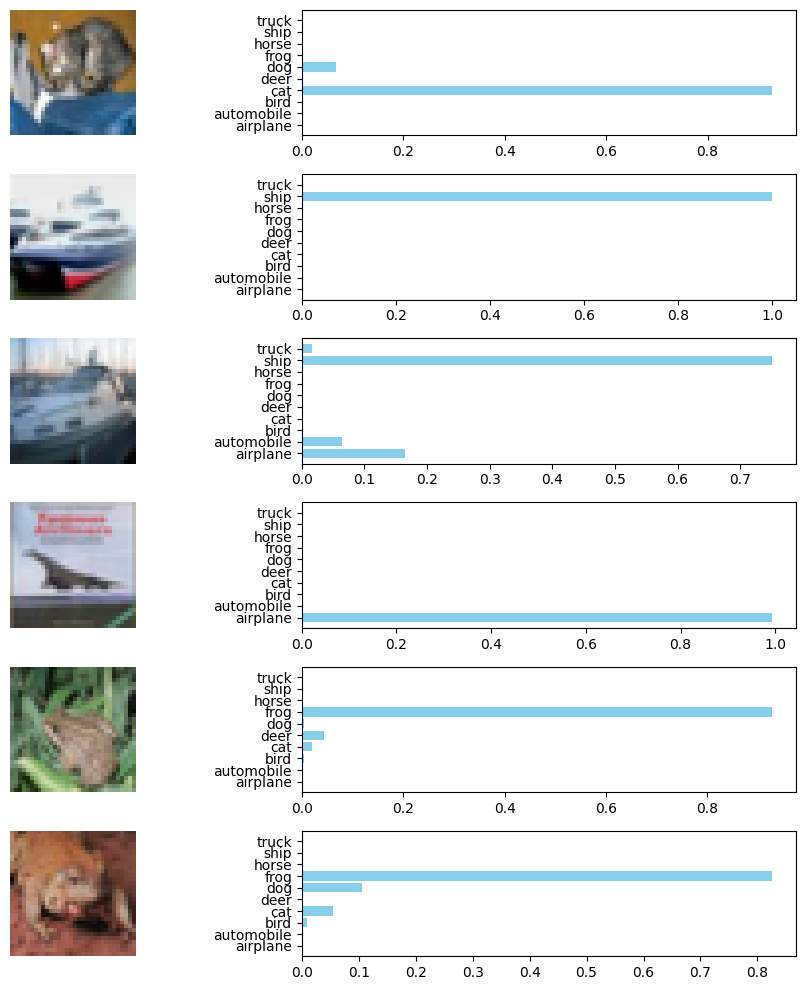

In [84]:

plot_proba_from_model(model, test_dataset, range(6),device)